In [1]:
#from google.colab import drive 
#drive.mount('/content/drive')

In [2]:
from keras import backend as K
K.clear_session()

In [3]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
#Importing all the libraries needed
import keras
import tensorflow
import h5py
from keras import optimizers, preprocessing, Input
from keras.models import load_model, Model
from keras.layers import Bidirectional
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import  plot_model
import os
import itertools
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.applications.inception_v3 import InceptionV3
import nltk
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split

C:\Users\maruf\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
C:\Users\maruf\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\maruf\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence 

In [5]:
# text pre-processing functions
def clean_text(text):
    text = text.replace('\nBULLET::::', ' ')
    text = text.replace('BULLET::::-', ' ')
    text = text.replace('BULLET::::', ' ')
    text = text.replace('\n', ' ')
    text = text.replace('\n\n', ' ')
    text = text.replace(r',', '')
    text = text.replace('.', '')
    text = text.replace(' - ', '')
    text = text.replace('-', '')
    text = text.replace('&nbsp;', ' ')
    text = text.replace('Page', ' ')
    text = text.replace(':', ' ')
    text = text.replace(';', ' ')
    text = text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace('(', '')
    text = text.replace('[', '')
    text = text.replace(']', '')
    text = text.replace(')', '')
    text = text.strip()
    text = re.sub(r'\d+.', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text

def get_tamil_stop_words():
    swdf1 = pd.read_csv("D:\\My Research\SHared Task\\Stopwords\\TamilNLP_TamilStopWords.txt",  header=None) 
    swdf2 = pd.read_csv("D:\\My Research\SHared Task\\Stopwords\\TamilNLP_TamilStopWords.txt",  header=None) 
    sw1 = swdf1[0].tolist()
    sw2 = swdf2[0].tolist()
    tamil_stop_words = list(set(sw1 + sw2))
    return tamil_stop_words

In [6]:
tamil_stop_words = get_tamil_stop_words()

In [7]:
#LSTM Implementation

In [8]:
Training_path = 'D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\train_captions_final.csv'
Testing_path = 'D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\test_captions.csv'
Validation_path = 'D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\test_captions_final.csv'


In [9]:
def read_data(file_name):
  #Opening file
    with open(file_name,'r', encoding="utf8",newline='\n', errors='ignore') as f:
      #Creating empty set and dictonary for vocab and word respectively
        word_vocab = set() 
        word2vector = {}
        #Iterating over each line of file
        for line in f:
            #Spliting lines
            line_ = line.strip() 
            #Splitting words
            words_Vec = line_.split()            
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [10]:
def encode_label(DataFrame, Label_col):
    t_y = DataFrame[Label_col].values
    Encoder = LabelEncoder()
    y = Encoder.fit_transform(t_y)
    DataFrame[Label_col] = y

In [11]:
def preprocess_text(Training_path,Validation_path, Testing_path):
    # function to preprocess input
    training_DF = pd.read_csv(Training_path, sep = ',')
    validation_DF = pd.read_csv(Validation_path, sep = ',')
    testing_DF = pd.read_csv(Testing_path, sep = ',')

    # encoding all the labels 
    encode_label(testing_DF,'label')
    encode_label(training_DF, 'label')
    encode_label(validation_DF, 'label')
    
    training_DF['sentence'] = training_DF['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tamil_stop_words)]))      
    validation_DF['sentence'] = validation_DF['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tamil_stop_words)]))
    testing_DF['sentence'] = testing_DF['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tamil_stop_words)]))

    # Processing the text
    training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
    testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
    validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

    return training_DF, testing_DF, validation_DF

In [12]:
#splitting data into train, test and validation
training_df, testing_df, validation_df = preprocess_text(Training_path,Validation_path, Testing_path)

In [13]:
maxlen = 1000
EMBEDDING_DIM = 300

In [14]:
#model with adam optimizer
adam = tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = tensorflow.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.9, epsilon=None, decay=0.0)

C:\Users\maruf\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
# Vectorising text
# process the whole observation into single list
train_text_list= list(training_df['sentence'])
test_text_list = list(testing_df['sentence'])
val_text_list = list(validation_df['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen)
x_val = preprocessing.sequence.pad_sequences(sequences_val, maxlen=maxlen)


y_test = testing_df['label']
y_train = training_df['label']
y_val = validation_df['label']

In [16]:
def img_text_generator(files, padded_seq, y, batch_size=None):
    """
        padded_seq: vectorized padded text sequence 
        y: label of the text
        batch_size: Number of observations to be selected at a time
        
        return: generator object of text data
    """
    while True:
        batch_idxs = np.random.choice(a = list(range(len(padded_seq))), size=batch_size) #Selecting the random batch indexes    
        batch_input_txt = [] # Initializing batch input text
        batch_input_img = [] # Initializing batch input image
        batch_output = [] # Initializing batch output
        
        # Traversing through the batch indexes
        for batch_idx in batch_idxs:
            input_txt = padded_seq[batch_idx] # selecting padded sequences from the batch
            output = y[batch_idx] # Selecting label  
            input_img = get_input(files[batch_idx])
            input_img = process_input(input_img)
            batch_input_txt.append(input_txt) # Appending the input (text vector)
            batch_input_img.append(input_img[0])
            batch_output.append(output) # Appending the label
        
        # Return a tuple of (input,output) to feed the network
        batch_x1 = np.array( batch_input_img )
        batch_x2 = np.array( batch_input_txt )
        batch_y = np.array( batch_output )
        yield ([batch_x1, batch_x2], batch_y)

In [17]:
def text_generator(padded_seq, y, batch_size=None):
    """
        padded_seq: vectorized padded text sequence 
        y: label of the text
        batch_size: Number of observations to be selected at a time
        
        return: generator object of text data
    """
    idxs = list(range(len(y)))
    idx = 0
    while True:
        batch_idxs = idxs[idx:idx+batch_size]
        idx = idx + batch_size
#         batch_idxs = np.random.choice(a = list(range(len(padded_seq))), size=batch_size) #Selecting the random batch indexes    
        batch_input = [] # Initializing batch input
        batch_output = [] # Initializing batch output
        
        # Traversing through the batch indexes
        for batch_idx in batch_idxs:
            input = padded_seq[batch_idx] # selecting padded sequences from the batch
            output = y[batch_idx] # Selecting label            
            batch_input.append(input) # Appending the input (text vector)
            batch_output.append(output) # Appending the label
        
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        if len(batch_x) < batch_size:
            idx = 0
        else:             
            yield (batch_x, batch_y)

In [18]:
def get_input(path):
    # Loading image from given path
    # and resizing it to 224*224*3 format
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img = image.load_img(path, target_size=(224,224))    
    return(img)

In [19]:
def get_output(path,label_file=None):
    # Spliting the path and take out the image id    
    filename = path.split('/')[-1]
    # Taking list of labels
    labels = list(label_file[label_file['image_name'] == filename]['label'].values)
  #  for duplicate selecting labels
    if len(labels) <= 2:
        label = labels[0]
    elif len(labels) > 2:
        uni_label = list(set(labels))
        count_label = [labels.count(lab) for lab in uni_label]
        lab_idx = count_label.index(max(count_label))
        label = uni_label[lab_idx]
    #label = labels[0]
    return label

In [20]:
def process_input(img):
    # Converting image to array    
    img_data = image.img_to_array(img)
    # Adding one more dimension to array    
    img_data = np.expand_dims(img_data, axis=0)
    #     
    img_data = preprocess_input(img_data)
    return(img_data)

In [21]:
 
# Creating train, test, val, generator for text
txt_gen_train = text_generator(x_train, y_train, batch_size=32)
txt_gen_test = text_generator(x_test, y_test, batch_size=1)
txt_gen_val = text_generator(x_val, y_val, batch_size=1)

# text_generator() Return a tuple of (padded sequences array,label array) to feed the network



In [22]:
# https://towardsdatascience.com/implementing-neural-machine-translation-using-keras-8312e4844eb8

In [23]:
# nice reading blog for this implementation


In [24]:
# from gensim.models import KeyedVectors
# model_ft = KeyedVectors.load_word2vec_format("D:\\My Research\\SHared Task\\cc.ta.300.vec")

In [25]:
# #embedding weight matrix

# embedding_matrix_1 = np.zeros((num_tokens + 1, EMBEDDING_DIM))

# count = 0 ;

# for word,i in word_index.items():

#     try:
#         embedding_matrix_1[i] = np.array(model_ft[word])
#         count = count + 1;  
#     except Exception:
#         ;

# print(count);
# print(embedding_matrix_1.shape)

In [26]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

# LSTM 

embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(10000, embedding_vecor_length, input_length=1000))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1_m])
print(model.summary())

subdir = "D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\";
filepath = os.path.join(subdir,"weights_best_resnest_txt.hdf5") 
checkpoint = ModelCheckpoint(filepath, monitor= "val_f1_m" , verbose=1, save_best_only=True, mode='max',save_weights_only=True)

callbacks_list = [checkpoint]

model.fit(x_train, y_train, epochs=10, batch_size=32,verbose = 1 , callbacks = callbacks_list, validation_data=(x_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 0.6353 - f1_m: 0.7274
Epoch 00001: val_f1_m improved from -inf to 0.42136, saving model to D:\My Research\SHared Task\Troll Meme\Tamil_troll_memes\tamil_memes_modified_Nusrat\weights_best_resnest_txt.hdf5
51/51 [=============================

In [27]:
#predicting the labels for the test set
y_pred_txt = (model.predict_generator(txt_gen_test, steps=663))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))

y_pred_txt



#true labels
#y_true = y_test.values
#y_true

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 1.

In [28]:
y_pred_txt = [ int(x) for x in y_pred_txt ]

In [29]:
print(y_test.values[:10])

[1 1 1 1 1 1 1 1 0 1]


In [30]:
only_text_df = pd.read_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\submit1.csv')

In [31]:
y_pred_txt

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,


In [32]:
count = 0;
for i in y_pred_txt:
    if i == 1:
      only_text_df['label'][count] = i;
    count = count + 1;

In [33]:
only_text_df['label'][0]

1

In [34]:
only_text_df.head()

,image_name,sentence,label
0,test_img_0.jpg,sugarkaga nadandhava vida figuregaga nadandhav...,1
1,test_img_1.jpg,i have come for my stones stones thaane.....,1
2,test_img_2.jpg,"""special porotta"" nu pottuierukke spacial kum ...",1
3,test_img_3.jpg,*we : amma .. cooker 3 whistle vanthuchu off p...,1
4,test_img_4.jpg,creating whatsapp group - 1st day vaanga ji.. ...,1


In [35]:
count = 0;
for i in y_pred_txt:
    if i == 1:
      only_text_df['label'][count] = "troll";
    else:
        only_text_df['label'][count] = "not_troll";
    count = count + 1;
count

663

In [36]:
only_text_df.head()

,image_name,sentence,label
0,test_img_0.jpg,sugarkaga nadandhava vida figuregaga nadandhav...,troll
1,test_img_1.jpg,i have come for my stones stones thaane.....,troll
2,test_img_2.jpg,"""special porotta"" nu pottuierukke spacial kum ...",troll
3,test_img_3.jpg,*we : amma .. cooker 3 whistle vanthuchu off p...,troll
4,test_img_4.jpg,creating whatsapp group - 1st day vaanga ji.. ...,troll


In [37]:
only_text_df.to_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\my_submit1.csv')

In [38]:
# Final evaluation of the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(10000, embedding_vecor_length, input_length=1000))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.load_weights(filepath)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
scores = model.evaluate(x_test, y_test, verbose=1,batch_size = 32)
print("Accuracy : %.2f%%" % (scores[1]*100))

21/21 [==============================] - 4s 148ms/step - loss: 1.7098 - f1_m: 0.6974
Accuracy : 69.74%


In [39]:
# CNN+LSTM create the model

embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(10000, embedding_vecor_length, input_length=1000))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
print(model.summary())

subdir = "D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\";
filepath = os.path.join(subdir,"weights_best_cnn.hdf5") 

checkpoint = ModelCheckpoint(filepath, monitor='val_f1_m', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]


model.fit(x_train, y_train, epochs=7, batch_size=32,verbose = 1 , callbacks = callbacks_list, validation_data=(x_val,y_val))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 32)          320000    
                                                                 
 conv1d (Conv1D)             (None, 1000, 32)          3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 32)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
________________________________________________

In [40]:

import os         # Creating a directory
model.save('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\CNN_LSTM_Text_model.h5')   # Saving model

In [41]:
#predicting the labels for the test set
y_pred_txt = (model.predict_generator(txt_gen_test, steps=663))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))

y_pred_txt



C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


array([0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1.

In [42]:
y_pred_txt = [ int(x) for x in y_pred_txt ]

In [43]:
only_text_df = pd.read_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\submit1.csv')

In [44]:
count = 0;
for i in y_pred_txt:
    if i == 1:
      only_text_df['label'][count] = "troll";
    else:
        only_text_df['label'][count] = "not_troll";
    count = count + 1;
count

663

In [45]:
only_text_df.to_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\my_submit2_txt.csv')

In [46]:
# Final evaluation of the model

embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(10000, embedding_vecor_length, input_length=1000))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
print(model.summary())
model.load_weights(filepath)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 32)          320000    
                                                                 
 conv1d_1 (Conv1D)           (None, 1000, 32)          3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 500, 32)          0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
________________________________________________

In [47]:
#Image Model


In [48]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["OMP_NUM_THREADS"] = "4"

In [49]:
from keras import regularizers

In [50]:
import keras
import tensorflow
from tensorflow.keras.applications.mobilenet import MobileNet

In [51]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout

from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, VGG16, xception, ResNet50
from keras.applications.mobilenet import preprocess_input
from keras.applications.vgg16 import preprocess_input
# from keras.applications.xception import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
from IPython.display import Image


In [52]:
#Importing all the libraries needed
import keras
import tensorflow
import h5py
from keras import optimizers, preprocessing, Input
from keras.models import load_model, Model
from keras.layers import Bidirectional
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import  plot_model
import os
import itertools
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.applications.inception_v3 import InceptionV3
import nltk
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split

In [53]:
#model with adam optimizer
adam = tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = tensorflow.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.9, epsilon=None, decay=0.0)

C:\Users\maruf\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [54]:
path_troll = os.path.realpath("D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\Troll_meme\\train\\troll")
path_NOT = os.path.realpath("D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\Troll_meme\\train\\Not_troll")

In [55]:
path_troll

'D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\Troll_meme\\train\\troll'

In [56]:
troll_img = os.listdir(path_troll)
dir_troll = [os.path.join(path_troll, filename) for filename in troll_img]
Not_troll_img = os.listdir(path_NOT)
dir_not = [os.path.join(path_NOT, filename) for filename in Not_troll_img]

In [57]:
print("# of troll images: ", len(troll_img), '\n',
      "# of not troll images: ", len(Not_troll_img))

# of troll images:  951 
 # of not troll images:  666


In [58]:

def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.vgg16.preprocess_input(img_array_expanded_dims)

In [59]:
def Image_model(base_model):
  #freezing all the trainable layers
  for layer in base_model.layers:
    layer.trainable = False
  #create output layer
  x = base_model.output
  #pooling layer before the output
  x = GlobalAveragePooling2D()(x)
  return x

In [60]:
base_model=ResNet50(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(1,activation='sigmoid')(x) #final layer with softmax activation

In [61]:
image_only_model = Model(inputs=base_model.input,outputs=preds)

In [62]:
for i,layer in enumerate(image_only_model.layers):
    print(i,layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [63]:
for layer in image_only_model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in image_only_model.layers[:155]:
    layer.trainable=False
for layer in image_only_model.layers[155:]:
    layer.trainable=True


In [64]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
test_generator=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory('D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\Troll_meme\\train',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=True)
test_generator = test_generator.flow_from_directory('D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\Troll_meme\\test',
                                                 target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=1,
                                                  class_mode='binary',
                                                 shuffle=True)

Found 1617 images belonging to 2 classes.
Found 663 images belonging to 2 classes.


In [65]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1])

In [66]:
np.unique(train_generator.classes)

array([0, 1])

In [67]:
# Addressing imbalanced data with class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes)

In [68]:
class_weights

array([1.21396396, 0.85015773])

In [69]:
image_only_model.compile(optimizer=adam,loss='binary_crossentropy',metrics=[f1_m])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
image_only_model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=7)

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/7
50/50 [==============================] - 223s 4s/step - loss: 0.3000 - f1_m: 0.8987
Epoch 2/7
50/50 [==============================] - 220s 4s/step - loss: 0.0669 - f1_m: 0.9821
Epoch 3/7
50/50 [==============================] - 219s 4s/step - loss: 0.0363 - f1_m: 0.9890
Epoch 4/7
50/50 [==============================] - 259s 5s/step - loss: 0.0134 - f1_m: 0.9970
Epoch 5/7
50/50 [==============================] - 275s 6s/step - loss: 0.0277 - f1_m: 0.9936
Epoch 6/7
50/50 [==============================] - 243s 5s/step - loss: 0.0190 - f1_m: 0.9958
Epoch 7/7
50/50 [==============================] - 249s 5s/step - loss: 0.0090 - f1_m: 0.9977


In [70]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Confution Matrix and Classification Report
Y_pred = image_only_model.predict_generator(test_generator, steps=663)
y_pred = np.round(list(itertools.chain(*Y_pred)))
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['troll', 'Not_troll']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Confusion Matrix
[[179 163]
 [158 163]]
Classification Report
              precision    recall  f1-score   support

       troll       0.53      0.52      0.53       342
   Not_troll       0.50      0.51      0.50       321

   micro avg       0.52      0.52      0.52       663
   macro avg       0.52      0.52      0.52       663
weighted avg       0.52      0.52      0.52       663



In [71]:
Y_pred = [ int(x) for x in Y_pred ]

In [72]:
only_text_df = pd.read_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\submit1.csv')

In [73]:
count = 0;
for i in Y_pred:
    if i == 0:
      only_text_df['label'][count] = "troll";
    else:
        only_text_df['label'][count] = "not_troll";
    count = count + 1;
count

663

In [74]:
only_text_df.to_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\my_submit1_img_resnet.csv', index = 'false')

In [75]:
def create_img_array(img_dirct):
    all_imgs = []
    for root, j, files in os.walk(img_dirct):
        for file in files:
            file = root + '/' + file
            all_imgs.append(file)
    return all_imgs

def create_img_path(DF, Col_name, img_dir):
    img_path = [img_dir + '/' + name for name in DF[Col_name]]
    return img_path

In [76]:
# Processing image 
img_dir = "D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\uploaded_tamil_memes"

img_dir_test = "D:\\My Research\\SHared Task\\Troll Meme\\Tamil_troll_memes\\test_img"

In [77]:
train_img_path = create_img_path(training_df,'image_name', img_dir)
test_img_path = create_img_path(testing_df,'image_name', img_dir_test)
val_img_path = create_img_path(validation_df,'image_name', img_dir)



In [78]:
def img_text_generator(files, padded_seq, y, batch_size=None):
    """
        padded_seq: vectorized padded text sequence 
        y: label of the text
        batch_size: Number of observations to be selected at a time
        
        return: generator object of text data
    """
    while True:
        batch_idxs = np.random.choice(a = list(range(len(padded_seq))), size=batch_size) #Selecting the random batch indexes    
        batch_input_txt = [] # Initializing batch input text
        batch_input_img = [] # Initializing batch input image
        batch_output = [] # Initializing batch output
        
        # Traversing through the batch indexes
        for batch_idx in batch_idxs:
            input_txt = padded_seq[batch_idx] # selecting padded sequences from the batch
            output = y[batch_idx] # Selecting label  
            input_img = get_input(files[batch_idx])
            input_img = process_input(input_img)
            batch_input_txt.append(input_txt) # Appending the input (text vector)
            batch_input_img.append(input_img[0])
            batch_output.append(output) # Appending the label
        
        # Return a tuple of (input,output) to feed the network
        batch_x1 = np.array( batch_input_img )
        batch_x2 = np.array( batch_input_txt )
        batch_y = np.array( batch_output )
        yield ([batch_x1, batch_x2], batch_y)

In [79]:

# Creating train, test, val, generator for meme
img_txt_gen_train = img_text_generator(train_img_path, x_train, y_train, batch_size=32)
img_txt_gen_test = img_text_generator(test_img_path, x_test, y_test, batch_size=1)
img_txt_gen_val = img_text_generator(val_img_path, x_val, y_val, batch_size=1)

In [80]:
#Multimodal

In [81]:
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1_m])
image_only_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1_m])

In [82]:
#concatenating the output of both the classifiers(text and image)
con_layer = keras.layers.concatenate([model.output, image_only_model.output])
out = Dense(1, activation='sigmoid')(con_layer)

In [83]:
#Common Model
com_model = Model(inputs = [image_only_model.input, model.input], outputs=out)

In [84]:

com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1_m])

In [85]:
#Training the combined model
model3 = com_model.fit_generator(img_txt_gen_train, epochs=10, validation_steps = 150, steps_per_epoch=2, validation_data=img_txt_gen_val, shuffle=False)

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
2/2 [==============================] - 47s 37s/step - loss: 1.0897 - f1_m: 0.0000e+00 - val_loss: 0.9615 - val_f1_m: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 38s 32s/step - loss: 1.0998 - f1_m: 0.0000e+00 - val_loss: 1.0453 - val_f1_m: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 39s 34s/step - loss: 0.9967 - f1_m: 0.0000e+00 - val_loss: 0.9745 - val_f1_m: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 39s 33s/step - loss: 0.9478 - f1_m: 0.0000e+00 - val_loss: 0.9190 - val_f1_m: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 38s 33s/step - loss: 1.0102 - f1_m: 0.0000e+00 - val_loss: 0.8391 - val_f1_m: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 36s 31s/step - loss: 0.9890 - f1_m: 0.0000e+00 - val_loss: 0.8324 - val_f1_m: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 38s 33s/step - loss: 0.8963 - f1_m: 0.0000e+00 - val_loss: 0.7544 - val_f1_m: 0.0000e+00
Epoch 8/10
2/2 [===========

In [86]:

com_model.save('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\LSTM_Resnet_Multimodl_model.h5')   # Saving model

C:\Users\maruf\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [87]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Confution Matrix and Classification Report
Y_pred = com_model.predict_generator(img_txt_gen_test, steps=663)
y_pred = np.round(list(itertools.chain(*Y_pred)))

Y_pred = [ int(x) for x in Y_pred ]


C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


In [88]:
only_text_df = pd.read_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\submit1.csv')

count = 0;
for i in y_pred_txt:
    if i == 0:
      only_text_df['label'][count] = "troll";
    else:
        only_text_df['label'][count] = "not_troll";
    count = count + 1;
print(count);

only_text_df.to_csv('D:\\My Research\SHared Task\\Troll Meme\\Tamil_troll_memes\\tamil_memes_modified_Nusrat\\my_submit1_combined.csv', index = 'false')

663


In [89]:
#Evaluating combined model by calculating loss and accuracy using test file
com_model.evaluate_generator(img_txt_gen_test, steps=663)

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.71939617395401, 0.009049772284924984]

In [90]:
#text model loss and accuracy using test file
model.evaluate_generator(txt_gen_test, steps=663)

C:\Users\maruf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[2.8385684490203857, 0.0]

NameError: name 'model1' is not defined

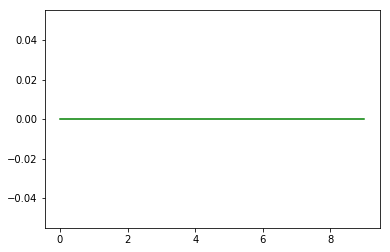

In [91]:
#plotting validation accuracy
plt.plot(model3.history['val_f1_m'],'g')
plt.plot(model1.history['val_f1_m'],'b')
plt.plot(model2.history['val_f1_m'],'r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.gca().legend(('meme model f1-score', 'text model f1-score', 'image model f1-score'))
plt.show()